In [5]:
from fake_models import MessageSql
from fake_config import Settings
from sqlalchemy import create_engine, asc, or_
from sqlalchemy.orm import sessionmaker
import dotenv
import pendulum
import requests
import datetime
import pytz
from datetime import datetime
import numpy as np
import json
import matplotlib.pyplot as plt

def from_dict_msg(data):
    message = MessageSql(
            message_id=data["MessageId"],
            from_alias=data["FromAlias"],
            message_type_name=data["MessageTypeName"],
            message_persisted_ms=data["MessagePersistedMs"],
            payload=data["Payload"],
            message_created_ms=data.get("MessageCreatedMs")  # This is optional
        )
    return message

# Load the list of messages from the JSON file
print('Reading json file...')
with open('messages.json', 'r') as file:
    messages_dict = json.load(file)
messages_loaded = [from_dict_msg(message_data) for message_data in messages_dict]
print("Opened messages from json")

Reading json file...
Opened messages from json


In [19]:
selected_messages = messages_loaded.copy()
start_ms = pendulum.datetime(2024, 12, 13, 7, tz="America/New_York").timestamp() * 1000 
end_ms = pendulum.datetime(2024, 12, 13, 13, 5, tz="America/New_York").timestamp() * 1000 
house_alias = 'beech'

all_channels = {}
for message in [x for x in selected_messages 
                if f'{house_alias}' in x.from_alias
                and x.message_persisted_ms >= start_ms-15*60*1000
                and x.message_persisted_ms <= end_ms+15*60*1000]:
    for channel in message.payload['ChannelReadingList']:
        # Find the channel name
        if message.message_type_name == 'report':
            channel_name = channel['ChannelName']
        elif message.message_type_name == 'batched.readings':
            for dc in message.payload['DataChannelList']:
                if dc['Id'] == channel['ChannelId']:
                    channel_name = dc['Name']
        # Store the values and times for the channel
        if 'gw-temp' in channel_name:
            if channel_name not in all_channels:
                all_channels[channel_name] = {
                    'values': channel['ValueList'],
                    'times': channel['ScadaReadTimeUnixMsList']
                }
            else:
                all_channels[channel_name]['values'].extend(channel['ValueList'])
                all_channels[channel_name]['times'].extend(channel['ScadaReadTimeUnixMsList'])

for key in all_channels.keys():
    sorted_times_values = sorted(zip(all_channels[key]['times'], all_channels[key]['values']))
    sorted_times, sorted_values = zip(*sorted_times_values)
    all_channels[key]['values'] = list(sorted_values)
    all_channels[key]['times'] = list(sorted_times)

zones_gw_temps = []
for channel_name in all_channels.keys():
    if 'gw-temp' in channel_name:
        all_channels[channel_name]['values'] = [x/1000 for x in all_channels[channel_name]['values']]
        zones_gw_temps.append(channel_name)

print(zones_gw_temps)

['zone1-down-gw-temp', 'zone2-up-gw-temp']



zone1-down-gw-temp
Temp start: 68.68
Temp end: 68.52
Energy stored in house: -0.64 kWh


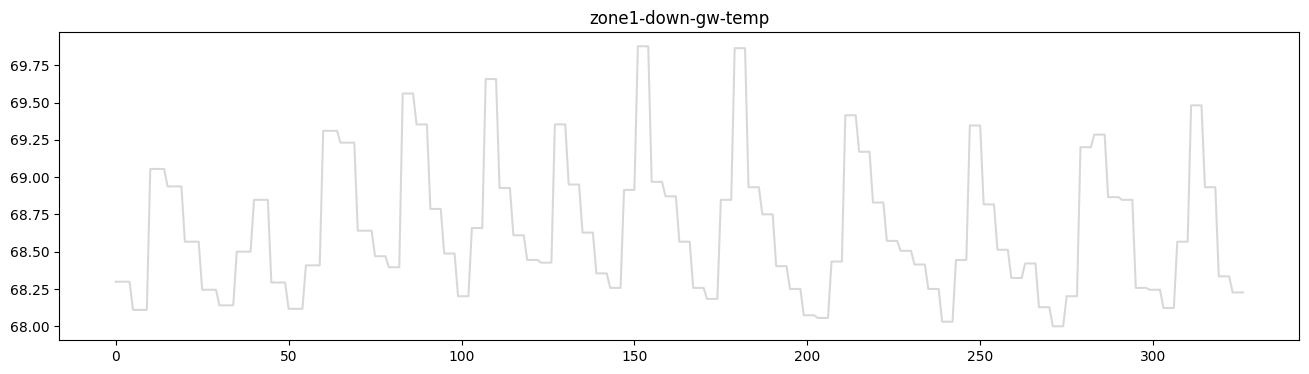


zone2-up-gw-temp
Temp start: 63.74
Temp end: 64.89


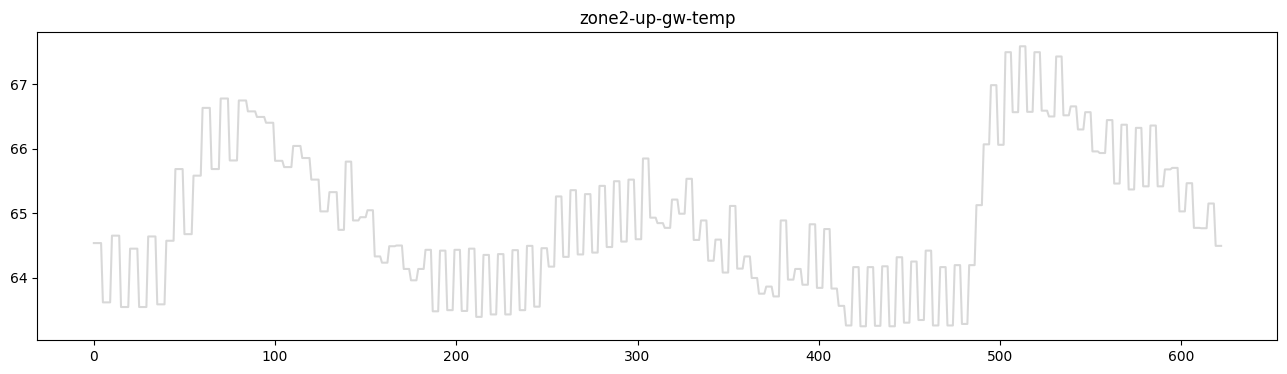

In [24]:
temp_start, temp_end = {}, {}
energy_stored_in_house = 0

def to_fahrenheit(t):
    return t*9/5+32

for zone in zones_gw_temps:
    print(f"\n{zone}")
    chn = all_channels[zone]
 
    temperatures = [
        value for time, value 
        in zip(chn['times'], chn['values']) 
        if time < end_ms
        and time > start_ms - 15*60*1000
        ]
    temperatures_no_tail = [
        value for time, value 
        in zip(chn['times'], chn['values']) 
        if time < end_ms
        and time > start_ms
        ]
    tail_size = len(temperatures) - len(temperatures_no_tail)
    
    alpha = 0.1
    smoothed_temperatures = [temperatures[0]]*len(temperatures)
    for t in range(len(temperatures)-1):
        smoothed_temperatures[t+1] = (1-alpha)*smoothed_temperatures[t] + alpha*temperatures[t+1]
    smoothed_temperatures = [to_fahrenheit(x) for x in smoothed_temperatures[tail_size:]]
    temperatures = [to_fahrenheit(x) for x in temperatures[tail_size:]]

    temp_start[zone] = round(smoothed_temperatures[0],2)
    temp_end[zone] = round(smoothed_temperatures[-1],2)

    print(f"Temp start: {temp_start[zone]}")
    print(f"Temp end: {temp_end[zone]}")

    if 'zone1' in zone:
        thermal_mass = 4 #kWh/degF
        energy_stored_in_house += round(thermal_mass * (temp_end[zone] - temp_start[zone]),2)
        print(f"Energy stored in house: {energy_stored_in_house} kWh")

    plt.figure(figsize=(16,4))
    plt.title(zone)
    plt.plot(range(len(temperatures)), temperatures, alpha=0.3, color='gray')
    # plt.plot(range(len(smoothed_temperatures)), smoothed_temperatures, alpha=0.3, color='red')
    # plt.plot([0, len(smoothed_temperatures)-1], [temp_start[zone], temp_end[zone]], '-x')
    plt.show()